# Title: Analysis of Intergenerational Mobility in Education

This notebook explores the ABM generated data of different scenarios and replications.

In [62]:
import mesa
import numpy as np
import random
import networkx as nx 
import bisect
from pathlib import Path
import os
import sys
import csv
import pandas as pd

# Basic paths
src_path = str(Path.cwd().parent / "scripts")
sys.path.append(src_path)

project_path = Path().resolve().parent
csv_path = project_path / "data"

# Python file stored in script folder
from data_cleaning import *

# Raw Data
🔹 Useful for step-wise analyses. \
🔹 All the agents' information at each step.

In [17]:
'''
    Read raw data
'''
num_scen = 3
num_reps = 10

rdfs = []
for j in range(1, num_scen+1):
    for i in range(1, num_reps+1):
        file_name = f"scenario{j}_rep{i}.csv"
        rdf = pd.read_csv(csv_path/file_name)
        rdf['Scenario'] = j
        rdf['Replication'] = i
        rdfs.append(rdf)

In [18]:
rdfs[0]

Step  AgentID  Age  Education Gender   Income  Spouse       Parents  \
0          0        0   22          4      M  383.912     NaN            []   
1          0        1   59          2      F  572.317     NaN            []   
2          0        2   46          2      F  207.210     NaN            []   
3          0        3   31          1      M  524.950     NaN            []   
4          0        4   30          3      F  208.252     NaN            []   
...      ...      ...  ...        ...    ...      ...     ...           ...   
148686   499     5328   10          4      M  679.790     NaN  [5301, 5276]   
148687   499     5329   10          5      M  773.909     NaN  [5303, 5293]   
148688   499     5330    8          4      M  782.493     NaN  [5303, 5293]   
148689   499     5331    8          5      M  702.780     NaN  [5306, 5300]   
148690   499     5332    6          5      M  393.503     NaN  [5306, 5300]   

        Generation  Cohort    Children     Weight               Capital  Brut  \
0                1       2  [525, 722]  [4, 9, 6]      [0.56, 0.456, 0]   NaN   
1                1       1          []  [3, 7, 9]      [0.26, 0.608, 0]   NaN   
2                1       1          []  [3, 4, 7]      [0.26, 0.181, 0]   NaN   
3                1       2          []  [1, 7, 8]      [0.11, 0.558, 0]   NaN   
4                1       2  [633, 668]  [7, 5, 4]      [0.51, 0.195, 0]   NaN   
...            ...     ...         ...        ...                   ...   ...   
148686          53      55          []  [7, 7, 1]   [0.68, 0.722, 0.97]  32.0   
148687          53      55          []  [4, 3, 1]   [0.7, 0.629, 0.912]  31.0   
148688          53      55          []  [1, 4, 1]   [0.44, 0.685, 0.97]  32.0   
148689          53      55          []  [2, 7, 3]    [0.6, 0.747, 0.97]  32.0   
148690          53      55          []  [7, 8, 1]  [0.85, 0.443, 0.971]  33.0   

        Scenario  Replication  
0              1            1  
1              1            1  
2              1            1  
3              1            1  
4              1            1  
...          ...          ...  
148686         1            1  
148687         1            1  
148688         1            1  
148689         1            1  
148690         1            1  

[148691 rows x 16 columns]

# Data Cleaning
🔹 Useful when a flattened data for each agent is required. \
🔹 Here, you cannot analyze with regard to time steps.

In [14]:
"""
    Load the data
    Run this only if you already have the data sets. Otherwise, next line.
"""
num_scen = 3
num_reps = 10

dfs = []
for j in range(1, num_scen+1):
    for i in range(1, num_reps+1):
        file_name = f"s{j}r{i}_analysis.csv"
        df = pd.read_csv(csv_path/file_name, index_col=0)
        df['Scenario'] = j
        df['Replication'] = i
        dfs.append(df)

In [2]:
"""
    Run this only when data sets aren't provided. Warning: it takes long to run!! 
"""
# num_scen = 3
# num_reps = 10
# dfs = []
# for j in range(1, num_scen+1):
#     for i in range(1, num_reps+1):
#         file_name = f"scenario{j}_rep{i}.csv"
#         df = process_data(csv_path / file_name)
#         df['Scenario'] = j
#         df['Replication'] = i
#         dfs.append(df)

In [5]:
dfs[10]

AgentID  Step  Age  Edu_level Gender   Income  Generation  Cohort  \
0           0     0   46          3      F  525.366           1       1   
1           1    20   58          4      F  552.580           1       3   
2          10     1   47          1      F  592.263           1       1   
3         100     1   51          2      F  434.857           1       1   
4        1000    53   60          5      F  513.299           4       6   
...       ...   ...  ...        ...    ...      ...         ...     ...   
7232      995    54   62          4      M  614.759           4       6   
7233      996    58   70          3      F  201.748           4       6   
7234      997    54   62          5      M  775.373           5       6   
7235      998    55   64          4      F  484.957           5       6   
7236      999    54   62          3      F  682.823           4       6   

          Weight                     Capital  ...  Mother_Income  \
0      [9, 6, 7]      ['0.57', '0.525', '0']  ...            NaN   
1     [4, 10, 9]  ['0.56', '0.691', '0.413']  ...            NaN   
2     [10, 1, 7]   ['0.2', '0.407', '0.904']  ...            NaN   
3      [6, 5, 4]  ['0.32', '0.408', '0.827']  ...            NaN   
4      [6, 8, 9]   ['0.8', '0.577', '0.942']  ...        721.298   
...          ...                         ...  ...            ...   
7232   [3, 1, 9]  ['0.52', '0.423', '0.954']  ...        711.882   
7233   [7, 3, 7]  ['0.51', '0.164', '0.907']  ...        799.748   
7234   [7, 3, 1]   ['0.85', '0.63', '0.889']  ...        796.356   
7235   [9, 4, 1]  ['0.76', '0.424', '0.843']  ...        502.834   
7236   [3, 4, 8]  ['0.39', '0.597', '0.823']  ...        621.984   

      Father_Income  Mother_Cultural  Mother_Economic  Mother_Social  \
0               NaN              NaN              NaN            NaN   
1               NaN              NaN              NaN            NaN   
2               NaN              NaN              NaN            NaN   
3               NaN              NaN              NaN            NaN   
4           753.854             0.60            0.586          0.828   
...             ...              ...              ...            ...   
7232        653.918             0.60            0.801          0.804   
7233        764.927             0.56            0.700          0.905   
7234        380.924             1.00            0.547          0.404   
7235        488.990             0.75            0.629          0.613   
7236         57.366             0.42            0.583          0.524   

      Father_Cultural Father_Economic  Father_Social  Scenario  Replication  
0                 NaN             NaN            NaN         2            1  
1                 NaN             NaN            NaN         2            1  
2                 NaN             NaN            NaN         2            1  
3                 NaN             NaN            NaN         2            1  
4                0.55           0.565          0.697         2            1  
...               ...             ...            ...       ...          ...  
7232             0.54           0.572          0.570         2            1  
7233             0.56           0.813          0.943         2            1  
7234             1.00           0.429          0.275         2            1  
7235             0.75           0.336          0.638         2            1  
7236             0.48           0.054          0.358         2            1  

[7237 rows x 36 columns]

## Save CSV
🔻 Save the cleaened/processed data as CSV files (To analyze in R for Relative Mobility)

In [4]:
for i in range(1, num_scen*num_reps+1):
        df = dfs[i-1]
        # print('Scenario', df['Scenario'][0], 'Replication', df['Replication'][0])
        scen = df['Scenario'][0]
        rep = df['Replication'][0]
        df.to_csv(csv_path/f's{scen}r{rep}_analysis.csv')

# Data Exporation

The following two plots allow a primitive view on how the scenarios differ. 

## Per Cohort

In [343]:
# Create dictionary of dataframes
df_last = pd.DataFrame()
row=0

for j in range(1, num_scen + 1):
    for i in range(1, num_reps + 1):
        df = dfs[row]
        size = df.groupby(['Cohort']).size().reset_index(name='Size')
        size['key'] = f"s{j}-r{i}"
        df_last = pd.concat([df_last, size], ignore_index=True)
        row += 1

filtered = df_last[df_last['Cohort']==3]
filtered.groupby(['key']).first() 

Cohort  Size
key                 
s1-r1        3   209
s1-r10       3   213
s1-r2        3   228
s1-r3        3   209
s1-r4        3   204
s1-r5        3   216
s1-r6        3   206
s1-r7        3   225
s1-r8        3   204
s1-r9        3   204
s2-r1        3   199
s2-r10       3   209
s2-r2        3   204
s2-r3        3   214
s2-r4        3   222
s2-r5        3   209
s2-r6        3   214
s2-r7        3   221
s2-r8        3   209
s2-r9        3   208
s3-r1        3   211
s3-r10       3   204
s3-r2        3   216
s3-r3        3   223
s3-r4        3   221
s3-r5        3   207
s3-r6        3   206
s3-r7        3   219
s3-r8        3   208
s3-r9        3   211

In [340]:
df_last

Cohort  Size     key
0          1   232   s1-r1
1          2   218   s1-r1
2          3   209   s1-r1
3          4   175   s1-r1
4          5   146   s1-r1
...      ...   ...     ...
1746      61    34  s3-r10
1747      62    32  s3-r10
1748      63    18  s3-r10
1749      64     3  s3-r10
1750      65     1  s3-r10

[1751 rows x 3 columns]

In [339]:
df_last.groupby('Cohort')['Size'].var().reset_index().head(60)

Cohort        Size
0        1  107.351724
1        2  143.650575
2        3   53.840230
3        4   66.924138
4        5  105.154023
5        6  112.298851
6        7  355.958621
7        8  487.085057
8        9  380.185057
9       10  432.891954
10      11  504.386207
11      12  455.757471
12      13  403.688506
13      14  534.878161
14      15  500.993103
15      16  401.429885
16      17  393.512644
17      18  362.464368
18      19  406.455172
19      20  475.236782
20      21  414.386207
21      22  536.993103
22      23  456.850575
23      24  473.788506
24      25  490.395402
25      26  444.326437
26      27  511.655172
27      28  526.326437
28      29  631.926437
29      30  635.972414
30      31  584.754023
31      32  572.116092
32      33  499.843678
33      34  462.516092
34      35  462.047126
35      36  450.460920
36      37  475.803448
37      38  442.960920
38      39  489.085057
39      40  539.291954
40      41  591.540230
41      42  650.455172
42      43  710.717241
43      44  733.981609
44      45  640.965517
45      46  691.566502
46      47  587.830688
47      48  598.199430
48      49  567.581538
49      50  451.626667
50      51  370.173333
51      52  396.160000
52      53  401.640000
53      54  420.432971
54      55  421.723320
55      56  428.251082
56      57  403.426901
57      58  505.970588
58      59  310.209524
59      60  245.552381

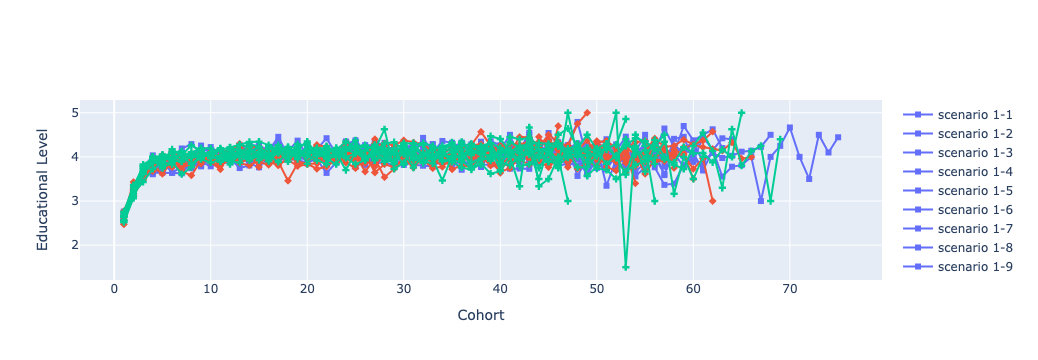

In [289]:
import plotly.graph_objects as go
import plotly.express as px


# Create dictionary of dataframes
df_dict = {}
row=0
for j in range(1, num_scen+1):
    for i in range(1, num_reps+1):
        key = f"scenario {j}"
        df = dfs[row]
        df_mean = df.groupby(['Cohort'], as_index=False).Edu_level.mean()
        if key in df_dict:
            df_dict[key].append(df_mean)
        else:
            df_dict[key] = [df_mean]
        row += 1

# Create list of replications and scenarios
replications = [f"rep {i}" for i in range(1, num_reps+1)]
scenarios = [f"scenario {j}" for j in range(1, num_scen+1)]
colors = [px.colors.qualitative.Plotly[0], px.colors.qualitative.Plotly[1], px.colors.qualitative.Plotly[2]]
# Create figure
fig = go.Figure()


# Loop through each scenario
for i, scenario in enumerate(scenarios):
    # Get dataframes for current scenario
    dfs_scenario = df_dict[scenario]
    # Get color for current scenario
    color = colors[i]
    # color = f"hsl({(i/len(scenarios))*360}, 50%, 50%)"
    # Loop through each replication of the current scenario
    for j, df in enumerate(dfs_scenario):
        # Get name for current replication
        name = f"{scenario}-{j+1}"
        fig.add_trace(go.Scatter(x=df["Cohort"], y=df["Edu_level"],
                                  name=name,
                                  mode="lines+markers",
                                  line=dict(color=color),
                                  marker=dict(symbol=int(scenario[-1]))))


fig.update_layout(
    xaxis_title="Cohort",
    yaxis_title="Educational Level",
    # paper_bgcolor='rgba(0,0,0,0)',
    # plot_bgcolor = 'rgba(0,0,0,0)',
    # showlegend=False
)

# Show figure
fig.show()



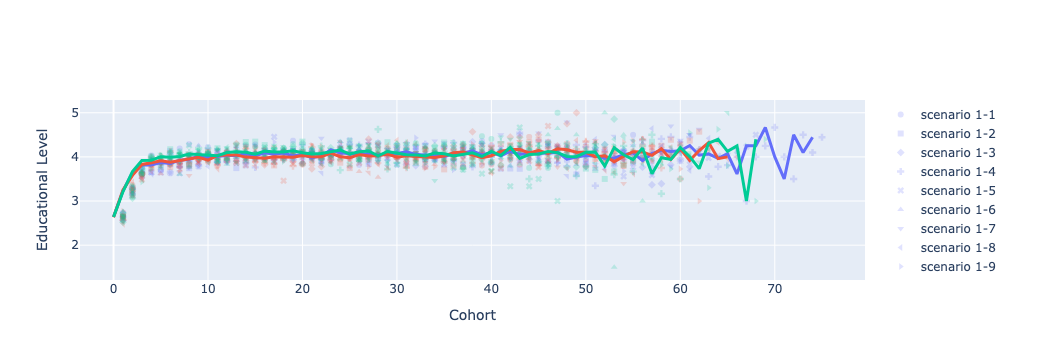

In [304]:
import plotly.graph_objects as go

# Create dictionary of dataframes
df_dict = {}
row=0
for j in range(1, num_scen+1):
    for i in range(1, num_reps+1):
        key = f"scenario {j}"
        df = dfs[row]
        df_mean = df.groupby(['Cohort'], as_index=False).Edu_level.mean()
        if key in df_dict:
            df_dict[key].append(df_mean)
        else:
            df_dict[key] = [df_mean]
        row += 1

# Create list of replications and scenarios
replications = [f"rep {i}" for i in range(1, num_reps+1)]
scenarios = [f"scenario {j}" for j in range(1, num_scen+1)]
colors = [px.colors.qualitative.Plotly[0], px.colors.qualitative.Plotly[1], px.colors.qualitative.Plotly[2]]

# Create figure
fig = go.Figure()

# Loop through each scenario
for i, scenario in enumerate(scenarios):
    # Get dataframes for current scenario
    dfs_scenario = df_dict[scenario]
    # Get color for current scenario
    color = colors[i]
    # Loop through each replication of the current scenario
    for j, df in enumerate(dfs_scenario):
        # Get name for current replication
        name = f"{scenario}-{j+1}"
        fig.add_trace(go.Scatter(x=df["Cohort"], y=df["Edu_level"],
                                  name=name,
                                  mode="markers",
                                  marker=dict(symbol=j, color=color, opacity=0.2)))


# To make the lines appear on top of the scatter, make a new loop
for i, scenario in enumerate(scenarios):
    dfs_scenario = df_dict[scenario]
    # color2 = f"hsl({(i/len(scenarios))*360}, 100%, 35%)"
    # Calculate the average line for the current scenario
    max_length = max(len(df) for df in dfs_scenario)
    avg_line = pd.concat([df.loc[:max_length-1, "Edu_level"] for df in dfs_scenario], axis=1).mean(axis=1)
    avg_line = avg_line.reset_index(name="Edu_level").rename(columns={"index": "Cohort"})
    
    # Add the average line as a trace
    fig.add_trace(go.Scatter(
        x=avg_line["Cohort"], y=avg_line["Edu_level"],
        name=f"{scenario} (Avg)",
        mode="lines",
        line=dict(color=colors[i], width=3),
    ))

fig.update_layout(
    xaxis_title="Cohort",
    yaxis_title="Educational Level",
    # paper_bgcolor='rgba(0,0,0,0)',
    # plot_bgcolor = 'rgba(0,0,0,0)',
    # showlegend=False
)

# Show figure
fig.show()

In [295]:
fig.write_image(project_path/"images/general_trends_1.png", width=900, height = 500)

## Per Time Step (Raw Data)


In [361]:
# Create dictionary of dataframes
rdf_last = pd.DataFrame()
row=0

for j in range(1, num_scen + 1):
    for i in range(1, num_reps + 1):
        rdf = rdfs[row]
        size = rdf.groupby(['Step']).size().reset_index(name='Size')
        size['key'] = f"s{j}-r{i}"
        size['Scenario'] = j
        size['Replication'] = i
        rdf_last = pd.concat([rdf_last, size], ignore_index=True)
        row += 1

filtered2 = rdf_last[rdf_last['Size']<=200]
filtered2.groupby(['key']).first() 

Step  Size  Scenario  Replication
key                                      
s1-r1    286   199         1            1
s1-r10   401   191         1           10
s1-r2    374   198         1            2
s1-r3    265   199         1            3
s1-r4    355   198         1            4
s1-r5    403   199         1            5
s1-r6    476   199         1            6
s1-r7    273   192         1            7
s1-r8    404   199         1            8
s1-r9    319   193         1            9
s2-r10   301   196         2           10
s2-r2    498   194         2            2
s2-r3    249   197         2            3
s2-r5    257   196         2            5
s2-r6    401   199         2            6
s2-r7    319   200         2            7
s2-r8    412   196         2            8
s2-r9    424   193         2            9
s3-r1    255   198         3            1
s3-r10   460   196         3           10
s3-r3    386   182         3            3
s3-r4    237   199         3            4
s3-r5    263   198         3            5
s3-r6    280   196         3            6
s3-r7    264   197         3            7
s3-r8    305   200         3            8
s3-r9    362   199         3            9

In [380]:
filtered2 = rdf_last[rdf_last['Step']==300]
filtered2.groupby(['key']).first() 
# filtered2.groupby('Scenario')['Size'].mean()

Step  Size  Scenario  Replication
key                                      
s1-r1    300   235         1            1
s1-r10   300   363         1           10
s1-r2    300   368         1            2
s1-r3    300   242         1            3
s1-r4    300   346         1            4
s1-r5    300   248         1            5
s1-r6    300   453         1            6
s1-r7    300   132         1            7
s1-r8    300   255         1            8
s1-r9    300   263         1            9
s2-r1    300   461         2            1
s2-r10   300   201         2           10
s2-r2    300   334         2            2
s2-r3    300    20         2            3
s2-r4    300   394         2            4
s2-r5    300   107         2            5
s2-r6    300   373         2            6
s2-r7    300   238         2            7
s2-r8    300   310         2            8
s2-r9    300   318         2            9
s3-r1    300   127         3            1
s3-r10   300   384         3           10
s3-r2    300   336         3            2
s3-r3    300   297         3            3
s3-r4    300    64         3            4
s3-r5    300   185         3            5
s3-r6    300   201         3            6
s3-r7    300   111         3            7
s3-r8    300   247         3            8
s3-r9    300   382         3            9

In [352]:
last_step = pd.DataFrame()
row=0
for j in range(1, num_scen+1):
    for i in range(1, num_reps+1):
        rdf = rdfs[row]
        last_step.loc[row, 'Scenario'] = j
        last_step.loc[row, 'Replication'] = i
        last_step.loc[row, 'last_step'] = rdf.Step.max()
        row += 1

In [349]:
last_step.groupby('Scenario').last_step.mean()

Scenario
1.0    497.5
2.0    465.6
3.0    452.5
Name: last_step, dtype: float64

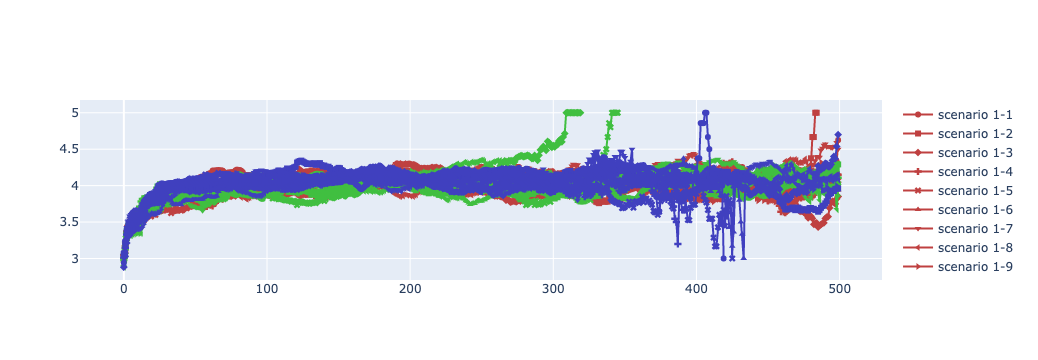

In [24]:
import plotly.graph_objects as go

# Create dictionary of dataframes
df_dict = {}
row=0
for j in range(1, num_scen+1):
    for i in range(1, num_reps+1):
        key = f"scenario {j}"
        rdf = rdfs[row]
        df_mean = rdf.groupby(['Step'], as_index=False).Education.mean()
        if key in df_dict:
            df_dict[key].append(df_mean)
        else:
            df_dict[key] = [df_mean]
        row += 1

# Create list of replications and scenarios
replications = [f"rep {i}" for i in range(1, num_reps+1)]
scenarios = [f"scenario {j}" for j in range(1, num_scen+1)]

# Create figure
fig = go.Figure()

# Loop through each scenario
for i, scenario in enumerate(scenarios):
    # Get dataframes for current scenario
    dfs_scenario = df_dict[scenario]
    # Get color for current scenario
    color = f"hsl({(i/len(scenarios))*360}, 50%, 50%)"
    # Loop through each replication of the current scenario
    for j, rdf in enumerate(dfs_scenario):
        # Get name for current replication
        name = f"{scenario}-{j+1}"
        fig.add_trace(go.Scatter(x=rdf["Step"], y=rdf["Education"],
                                  name=name,
                                  mode="lines+markers",
                                  line=dict(color=color),
                                  marker=dict(symbol=j)))

# Show figure
fig.show()



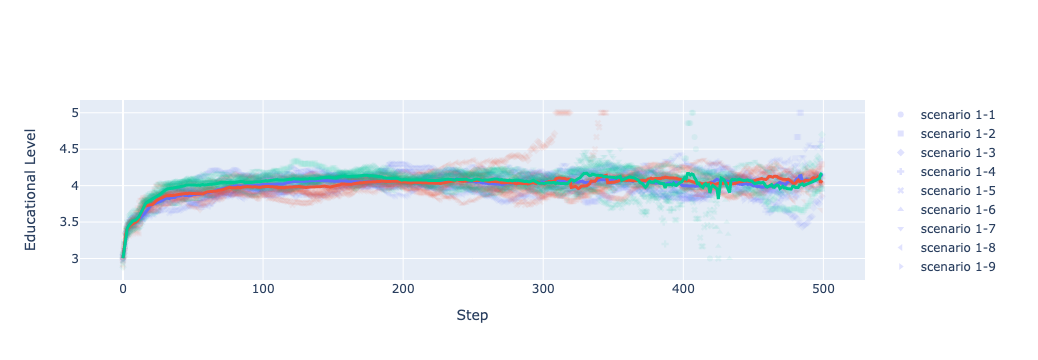

In [305]:
import plotly.graph_objects as go
import numpy as np
import pandas as pd

# Create dictionary of dataframes
df_dict = {}
row = 0
for j in range(1, num_scen+1):
    for i in range(1, num_reps+1):
        key = f"scenario {j}"
        rdf = rdfs[row]
        df_mean = rdf.groupby(['Step'], as_index=False).Education.mean()
        if key in df_dict:
            df_dict[key].append(df_mean)
        else:
            df_dict[key] = [df_mean]
        row += 1

# Create list of replications and scenarios
replications = [f"rep {i}" for i in range(1, num_reps+1)]
scenarios = [f"scenario {j}" for j in range(1, num_scen+1)]
colors = [px.colors.qualitative.Plotly[0], px.colors.qualitative.Plotly[1], px.colors.qualitative.Plotly[2]]

# Create figure
fig = go.Figure()

# Loop through each scenario
for i, scenario in enumerate(scenarios):
    # Get dataframes for current scenario
    dfs_scenario = df_dict[scenario]
    # Get color for current scenario
    color = colors[i]
    
    # Loop through each replication of the current scenario
    for j, rdf in enumerate(dfs_scenario):
        # Get name for current replication
        name = f"{scenario}-{j+1}"
        
        # Add scatter dots for each replication
        fig.add_trace(go.Scatter(
            x=rdf["Step"], y=rdf["Education"],
            name=name,
            mode="markers",
            marker=dict(symbol=j, color=color, opacity=0.07)
        ))


# To make the lines appear on top of the scatter, make a new loop
for i, scenario in enumerate(scenarios):
    dfs_scenario = df_dict[scenario]
    # Calculate the average line for the current scenario
    max_length = max(len(df) for df in dfs_scenario)
    avg_line = pd.concat([df.loc[:max_length-1, "Education"] for df in dfs_scenario], axis=1).mean(axis=1)
    avg_line = avg_line.reset_index(name="Education").rename(columns={"index": "Step"})
    
    # Add the average line as a trace
    fig.add_trace(go.Scatter(
        x=avg_line["Step"], y=avg_line["Education"],
        name=f"{scenario} (Avg)",
        mode="lines",
        line=dict(color=colors[i], width=3),
    ))

fig.update_layout(
    xaxis_title="Step",
    yaxis_title="Educational Level",
    # paper_bgcolor='rgba(0,0,0,0)',
    # plot_bgcolor = 'rgba(0,0,0,0)',
    # showlegend=False
)

# Show figure
fig.show()


In [303]:
fig.write_image(project_path/"images/general_trends_2.png", width=900, height = 500)

# Absolute Mobility

## Method 1

In [57]:
absolute = pd.DataFrame(columns=["Scenario", "Replication", "Cohort", "Probability"])
row = 0
for j in range(1, num_scen+1):
    for i in range(1, num_reps+1):
        df = dfs[row]
        am1 = df[(df['Mother_Edu'] < 5) & (df['Father_Edu'] <5)]
        am2 = df[(df['Mother_Edu'] == 5) | (df['Father_Edu'] ==5)]
        counts = am1[(am1['Edu_level'] > am1['Mother_Edu']) & (am1['Edu_level'] > am1['Father_Edu'])].groupby('Cohort').size()
        counts2 = am2[(am2['Edu_level'] == 5)].groupby('Cohort').size()
        totals = am1.groupby(['Cohort']).size()
        totals2 = am2.groupby('Cohort').size()
        probs = counts/totals
        probs2 = counts2 / totals2
        probs3 = probs2 + probs
        temp = pd.DataFrame({"Scenario": j, "Replication": i, "Cohort": probs.index, "Probability": probs.values})
        temp2 = pd.DataFrame({"Scenario": j, "Replication": i, "Cohort": probs3.index, "Probability": probs3.values})
        absolute = pd.concat([absolute, temp], ignore_index=True)
        absolute2 = pd.concat([absolute, temp2], ignore_index=True)
        row +=1

In [58]:
# absolute.drop('Replication')
abs1 = absolute.groupby(['Scenario', 'Cohort']).agg({'Probability': ["mean", "median", "var", "sem", "std"]}).reset_index()
abs1['ci95_hi'] = abs1['Probability']['mean'] + 1.96* abs1['Probability']['sem']
abs1['ci95_lo'] = abs1['Probability']['mean'] - 1.96* abs1['Probability']['sem']
# abs1.columns = abs1.columns.droplevel()
abs1.columns = ['_'.join(col) for col in abs1.columns]
abs1.rename(columns = {'Scenario_':'Scenario', 'Cohort_':'Cohort', 'ci95_hi_': 'ci95_hi', 'ci95_lo_':'ci95_lo'}, inplace = True)
abs1

Scenario  Cohort  Probability_mean  Probability_median  Probability_var  \
0           1       3          0.368278            0.372768         0.003509   
1           1       4          0.394438            0.373190         0.008489   
2           1       5          0.390056            0.390476         0.005815   
3           1       6          0.405786            0.398630         0.004566   
4           1       7          0.401345            0.385705         0.009663   
..        ...     ...               ...                 ...              ...   
197         3      64          0.500000            0.500000              NaN   
198         3      65               NaN                 NaN              NaN   
199         3      66          0.500000            0.500000              NaN   
200         3      67               NaN                 NaN              NaN   
201         3      69          0.500000            0.500000              NaN   

     Probability_sem  Probability_std   ci95_hi   ci95_lo  
0           0.018733         0.059239  0.404995  0.331562  
1           0.029136         0.092137  0.451545  0.337331  
2           0.024114         0.076255  0.437319  0.342792  
3           0.021367         0.067569  0.447666  0.363906  
4           0.031086         0.098303  0.462273  0.340416  
..               ...              ...       ...       ...  
197              NaN              NaN       NaN       NaN  
198              NaN              NaN       NaN       NaN  
199              NaN              NaN       NaN       NaN  
200              NaN              NaN       NaN       NaN  
201              NaN              NaN       NaN       NaN  

[202 rows x 9 columns]

In [60]:
'''
    To csv file for further analysis
'''

absolute.to_csv(csv_path/"absolute_measure1.csv")
absolute2.to_csv(csv_path/"absolute_measure2.csv")
abs1.to_csv(csv_path/"absolute_measure1_sum.csv")
abs2.to_csv(csv_path/"absolute_measure2_sum.csv")

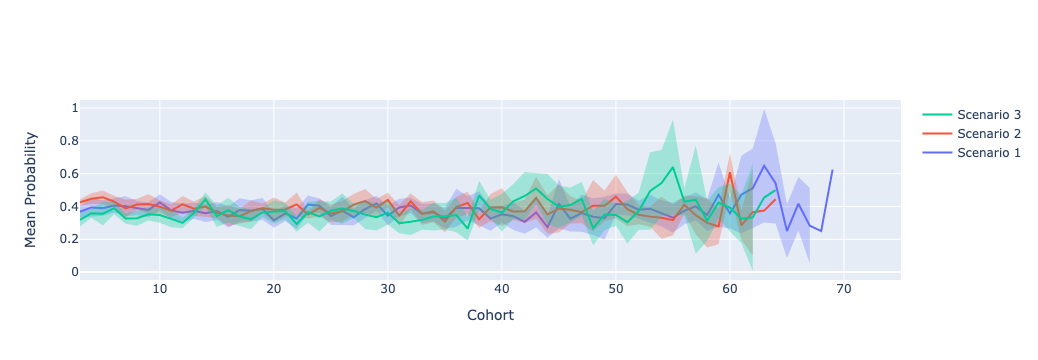

In [14]:
'''
    Continuous Graph
'''

import plotly.graph_objects as go

abs1["Scenario"] = abs1["Scenario"].astype(str)
scenarios = abs1["Scenario"].unique()

# Define a color map for the scenarios
color_map = {
    scenario: f"rgba({r}, {g}, {b}, 0.3)"
    for scenario, (r, g, b) in zip(scenarios, [(99, 109, 250), (239, 85, 59), (0, 204, 150)])
}




fig = go.Figure()

for scenario in scenarios:
    scenario_data = abs1[abs1["Scenario"] == scenario]
    
    fig.add_trace(go.Scatter(x=scenario_data['Cohort'],
                             y=scenario_data['Probability_mean'],
                             name=f'Scenario {scenario}',
                             mode='lines',
                             line=dict(color=color_map[scenario].replace('0.3', '1')))
                 )
    
    fig.add_trace(go.Scatter(x=scenario_data['Cohort'],
                             y=scenario_data['ci95_hi'],
                             name='Upper Bound of {}'.format(scenario),
                             mode='lines',
                             marker=dict(color="#444"),
                             line=dict(width=0),
                             showlegend=False))
    
    fig.add_trace(go.Scatter(x=scenario_data['Cohort'],
                             y=scenario_data['ci95_lo'],
                             name='Lower Bound of {}'.format(scenario),
                             mode='lines',
                             marker=dict(color="#444"),
                             line=dict(width=0),
                             showlegend=False,
                             fillcolor=color_map[scenario],
                             fill='tonexty'))
fig.update_layout(
    xaxis_title="Cohort",
    yaxis_title="Mean Probability",
    # paper_bgcolor='rgba(0,0,0,0)',
    # plot_bgcolor = 'rgba(0,0,0,0)',
    # showlegend=False
)

fig.show()

In [20]:
fig.write_image(project_path/"images/abs1_means2.png")
fig.write_html(project_path/"images/abs1_means.html") # with legend

## Method 2

In [59]:
# absolute.drop('Replication')
abs2 = absolute2.groupby(['Scenario', 'Cohort']).agg({'Probability': ["mean", "median", "var", "sem", "std"]}).reset_index()
abs2['ci95_hi'] = abs2['Probability']['mean'] + 1.96* abs2['Probability']['sem']
abs2['ci95_lo'] = abs2['Probability']['mean'] - 1.96* abs2['Probability']['sem']
abs2.columns = ['_'.join(col) for col in abs2.columns]
abs2.rename(columns = {'Scenario_':'Scenario', 'Cohort_':'Cohort', 'ci95_hi_': 'ci95_hi', 'ci95_lo_':'ci95_lo'}, inplace = True)
abs2

Scenario  Cohort  Probability_mean  Probability_median  Probability_var  \
0           1       3          0.368278            0.372768         0.003509   
1           1       4          0.394438            0.373190         0.008489   
2           1       5          0.390056            0.390476         0.005815   
3           1       6          0.405786            0.398630         0.004566   
4           1       7          0.401345            0.385705         0.009663   
..        ...     ...               ...                 ...              ...   
197         3      64          0.500000            0.500000              NaN   
198         3      65               NaN                 NaN              NaN   
199         3      66          0.500000            0.500000              NaN   
200         3      67               NaN                 NaN              NaN   
201         3      69          0.500000            0.500000              NaN   

     Probability_sem  Probability_std   ci95_hi   ci95_lo  
0           0.018733         0.059239  0.404995  0.331562  
1           0.029136         0.092137  0.451545  0.337331  
2           0.024114         0.076255  0.437319  0.342792  
3           0.021367         0.067569  0.447666  0.363906  
4           0.031086         0.098303  0.462273  0.340416  
..               ...              ...       ...       ...  
197              NaN              NaN       NaN       NaN  
198              NaN              NaN       NaN       NaN  
199              NaN              NaN       NaN       NaN  
200              NaN              NaN       NaN       NaN  
201              NaN              NaN       NaN       NaN  

[202 rows x 9 columns]

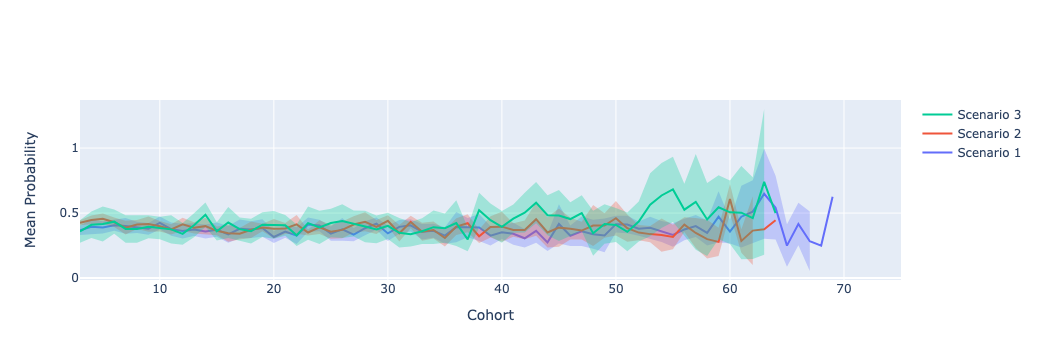

In [17]:
'''
    Continuous Graph
'''

import plotly.graph_objects as go

abs2["Scenario"] = abs2["Scenario"].astype(str)
scenarios = abs2["Scenario"].unique()

# Define a color map for the scenarios
color_map = {
    scenario: f"rgba({r}, {g}, {b}, 0.3)"
    for scenario, (r, g, b) in zip(scenarios, [(99, 109, 250), (239, 85, 59), (0, 204, 150)])
}




fig = go.Figure()

for scenario in scenarios:
    scenario_data = abs2[abs2["Scenario"] == scenario]
    
    fig.add_trace(go.Scatter(x=scenario_data['Cohort'],
                             y=scenario_data['Probability_mean'],
                             name=f'Scenario {scenario}',
                             mode='lines',
                             line=dict(color=color_map[scenario].replace('0.3', '1')))
                 )
    
    fig.add_trace(go.Scatter(x=scenario_data['Cohort'],
                             y=scenario_data['ci95_hi'],
                             name='Upper Bound of {}'.format(scenario),
                             mode='lines',
                             marker=dict(color="#444"),
                             line=dict(width=0),
                             showlegend=False))
    
    fig.add_trace(go.Scatter(x=scenario_data['Cohort'],
                             y=scenario_data['ci95_lo'],
                             name='Lower Bound of {}'.format(scenario),
                             mode='lines',
                             marker=dict(color="#444"),
                             line=dict(width=0),
                             showlegend=False,
                             fillcolor=color_map[scenario],
                             fill='tonexty'))
fig.update_layout(
    xaxis_title="Cohort",
    yaxis_title="Mean Probability",
    # paper_bgcolor='rgba(0,0,0,0)',
    # plot_bgcolor = 'rgba(0,0,0,0)',
    # showlegend=False
)

fig.show()

In [18]:
fig.write_image(project_path/"images/abs2_means.png")
fig.write_html(project_path/"images/abs2_means.html") # with legend

### All

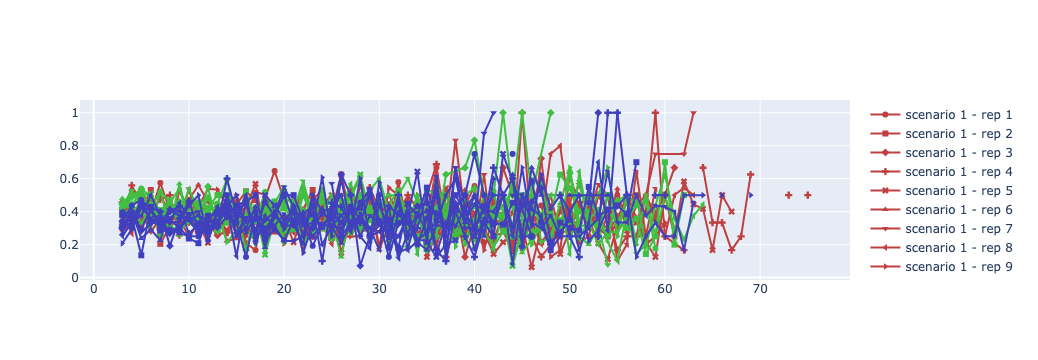

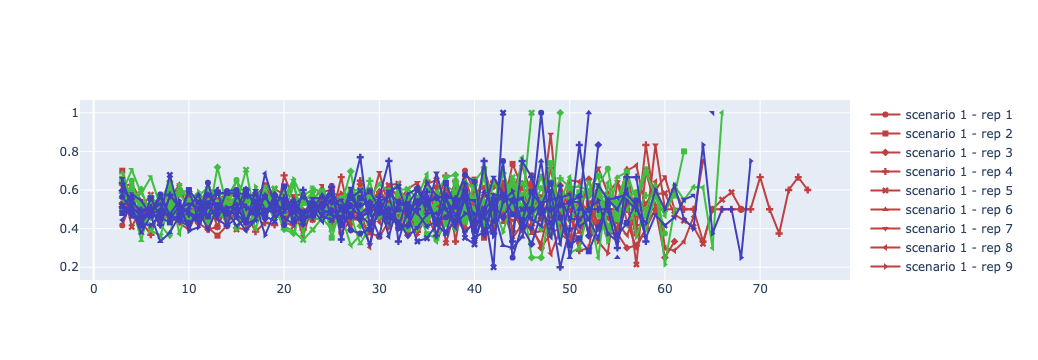

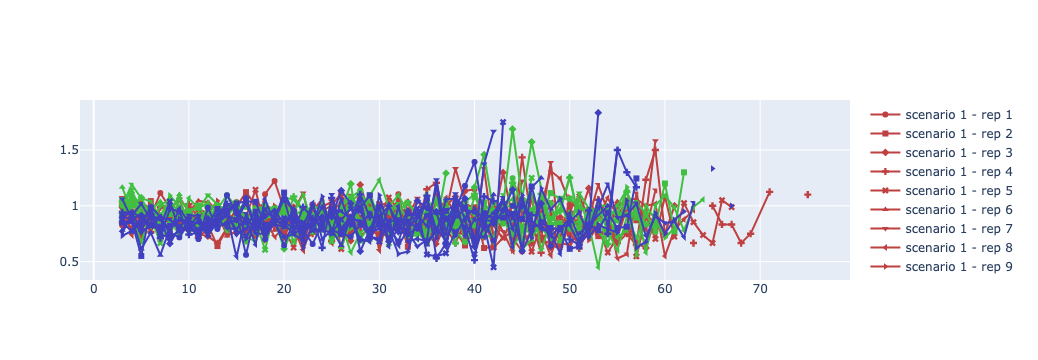

In [18]:
import plotly.graph_objects as go

# Create dictionary of dataframes
df_dict = {}
row = 0
for j in range(1, num_scen+1):
    for i in range(1, num_reps+1):
        key = f"scenario {j}"
        df = dfs[row]
        am1 = df[(df['Mother_Edu'] < 5) & (df['Father_Edu'] <5)]
        am2 = df[(df['Mother_Edu'] == 5) | (df['Father_Edu'] ==5)]
        counts = am1[(am1['Edu_level'] > am1['Mother_Edu']) & (am1['Edu_level'] > am1['Father_Edu'])].groupby('Cohort').size()
        counts2 = am2[(am2['Edu_level'] == 5)].groupby('Cohort').size()
        totals = am1.groupby(['Cohort']).size()
        totals2 = am2.groupby('Cohort').size()
        probs = counts/totals
        probs2 = counts2 / totals2
        probs3 = probs2 + probs
        if key in df_dict:
            df_dict[key].append({'Cohort': probs.index, 'Probability': probs.values, 'Cohort2': probs2.index, 'Probability2': probs2.values,
                                 'Probability3': probs3.values})
        else:
            df_dict[key] = [{'Cohort': probs.index, 'Probability': probs.values, 'Cohort2': probs2.index, 'Probability2': probs2.values,
                              'Probability3': probs3.values}]        
        row+=1

# Create list of replications and scenarios
replications = [f"rep {i}" for i in range(1, num_reps+1)]
scenarios = [f"scenario {j}" for j in range(1, num_scen+1)]

# Create figures
fig = go.Figure()
fig2 = go.Figure()
fig3 = go.Figure()

# Loop through each scenario
for i, scenario in enumerate(scenarios):
    # Get dataframes for current scenario
    dfs_scenario = df_dict[scenario]
    # Get color for current scenario
    color = f"hsl({(i/len(scenarios))*360}, 50%, 50%)"
    # Loop through each replication of the current scenario
    for j, df in enumerate(dfs_scenario):
        # Get name for current replication
        name = f"{scenario} - rep {j+1}"
        # Add traces to figures
        fig.add_trace(go.Scatter(x=df["Cohort"], y=df["Probability"],
                                  name=name,
                                  mode="lines+markers",
                                  line=dict(color=color),
                                  marker=dict(symbol=int(j))))
        fig2.add_trace(go.Scatter(x=df["Cohort2"], y=df["Probability2"],
                                   name=name,
                                   mode="lines+markers",
                                   line=dict(color=color),
                                   marker=dict(symbol=int(j))))
        fig3.add_trace(go.Scatter(x=df["Cohort"], y=df["Probability3"],
                                   name=name,
                                   mode="lines+markers",
                                   line=dict(color=color),
                                   marker=dict(symbol=int(j))))

# Show figures
fig.show()
fig2.show()
fig3.show()


# Relative Mobility
* See R Script

# Who Benefits?

In [19]:
dfs[0].columns

Index(['AgentID', 'Step', 'Age', 'Edu_level', 'Gender', 'Income', 'Generation',
       'Cohort', 'Weight', 'Capital', 'Brut', 'Child1', 'Child2', 'Mother',
       'Father', 'Partner', 'Education', 'Cultural', 'Economic', 'Social',
       'Child1_Edu', 'Child2_Edu', 'Child1_Income', 'Child2_Income',
       'Mother_Edu', 'Father_Edu', 'Mother_Income', 'Father_Income',
       'Mother_Cultural', 'Mother_Economic', 'Mother_Social',
       'Father_Cultural', 'Father_Economic', 'Father_Social', 'Scenario',
       'Replication'],
      dtype='object')

In [63]:
'''
    Make a function to create summary tables for each data set
'''
def summary_tab(df):
    ls = pd.DataFrame()
    row = 0
    for i in df.Cohort.unique():
        cht = df[df['Cohort'] == i]
        for j in range(1, 6):
            for k in range(1, 6):
                new = cht[(cht['Mother_Edu'] == j) | (cht['Father_Edu'] == k)]
                n = new.size
                avg = new['Edu_level'].mean()
                med = new['Edu_level'].median()
                ls.loc[row, 'Cohort'] = i
                ls.loc[row, 'Average Edu'] = avg
                ls.loc[row, 'Median Edu'] = med
                ls.loc[row, 'Total'] = n
                ls.loc[row, 'Mother Edu'] = j
                ls.loc[row, 'Father Edu'] = k
                row += 1
    return ls


In [64]:
ls_full = pd.DataFrame()
row = 0
for i in range(1, num_scen+1):
    for j in range(1,num_reps+1):
        df = dfs[row]
        df2 =  df[df['Generation'] != 1]
        df3 = summary_tab(df2)
        df3['Scenario'] = i
        df3['Replication'] = j
        ls_full = pd.concat([ls_full, df3], ignore_index=True)
        row +=1

In [65]:
# pd.set_option('display.max_rows', None)
ls_full

Cohort  Average Edu  Median Edu   Total  Mother Edu  Father Edu  \
0         7.0     3.888889         4.5   648.0         1.0         1.0   
1         7.0     3.954545         4.0   792.0         1.0         2.0   
2         7.0     3.950000         4.0  1440.0         1.0         3.0   
3         7.0     4.137255         4.0  1836.0         1.0         4.0   
4         7.0     4.343750         5.0  2304.0         1.0         5.0   
...       ...          ...         ...     ...         ...         ...   
42270    65.0     5.000000         5.0    36.0         5.0         1.0   
42271    65.0     5.000000         5.0    36.0         5.0         2.0   
42272    65.0     5.000000         5.0    36.0         5.0         3.0   
42273    65.0     5.000000         5.0    36.0         5.0         4.0   
42274    65.0     5.000000         5.0    36.0         5.0         5.0   

       Scenario  Replication  
0             1            1  
1             1            1  
2             1            1  
3             1            1  
4             1            1  
...         ...          ...  
42270         3           10  
42271         3           10  
42272         3           10  
42273         3           10  
42274         3           10  

[42275 rows x 8 columns]

In [157]:
# pd.set_option("display.max_rows", 25)

In [66]:
agg_ls = ls_full.groupby(['Scenario', 'Cohort', 'Mother Edu', 'Father Edu']).agg({'Average Edu': ["mean", "sem", "std"], 'Median Edu': ['mean', 'sem', 'std'] }).reset_index()
agg_ls['ci95_hi_avg'] = agg_ls['Average Edu']['mean'] + 1.96* agg_ls['Average Edu']['sem']
agg_ls['ci95_lo_avg'] = agg_ls['Average Edu']['mean'] - 1.96* agg_ls['Average Edu']['sem']
agg_ls['ci95_hi_med'] = agg_ls['Median Edu']['mean'] + 1.96* agg_ls['Median Edu']['sem']
agg_ls['ci95_lo_med'] = agg_ls['Median Edu']['mean'] - 1.96* agg_ls['Median Edu']['sem']
agg_ls.columns = ['_'.join(col) for col in agg_ls.columns]
agg_ls.rename(columns = {'Scenario_':'Scenario', 'Cohort_':'Cohort', 'Mother Edu_':'Mother Edu', 'Father Edu_':'Father Edu',
                         'ci95_hi_avg_': 'ci95_hi_avg', 'ci95_lo_avg_':'ci95_lo_avg',
                         'ci95_hi_med_': 'ci95_hi_med', 'ci95_lo_med_':'ci95_lo_med'}, inplace = True)

agg_ls['Parent Edu'] = agg_ls.apply(lambda x: [x['Mother Edu'], x['Father Edu']], axis=1)

agg_ls.head(5)

Scenario  Cohort  Mother Edu  Father Edu  Average Edu_mean  \
0         1     3.0         1.0         1.0          1.805588   
1         1     3.0         1.0         2.0          2.405332   
2         1     3.0         1.0         3.0          3.160301   
3         1     3.0         1.0         4.0          3.436475   
4         1     3.0         1.0         5.0          3.553121   

   Average Edu_sem  Average Edu_std  Median Edu_mean  Median Edu_sem  \
0         0.125877         0.398057              1.2        0.133333   
1         0.089751         0.283817              2.0        0.149071   
2         0.073470         0.232331              3.3        0.152753   
3         0.068618         0.216990              4.0        0.000000   
4         0.076782         0.242806              4.1        0.100000   

   Median Edu_std  ci95_hi_avg  ci95_lo_avg  ci95_hi_med  ci95_lo_med  \
0        0.421637     2.052307     1.558870     1.461333     0.938667   
1        0.471405     2.581244     2.229421     2.292180     1.707820   
2        0.483046     3.304301     3.016300     3.599395     3.000605   
3        0.000000     3.570967     3.301983     4.000000     4.000000   
4        0.316228     3.703614     3.402628     4.296000     3.904000   

   Parent Edu  
0  [1.0, 1.0]  
1  [1.0, 2.0]  
2  [1.0, 3.0]  
3  [1.0, 4.0]  
4  [1.0, 5.0]

## Plots

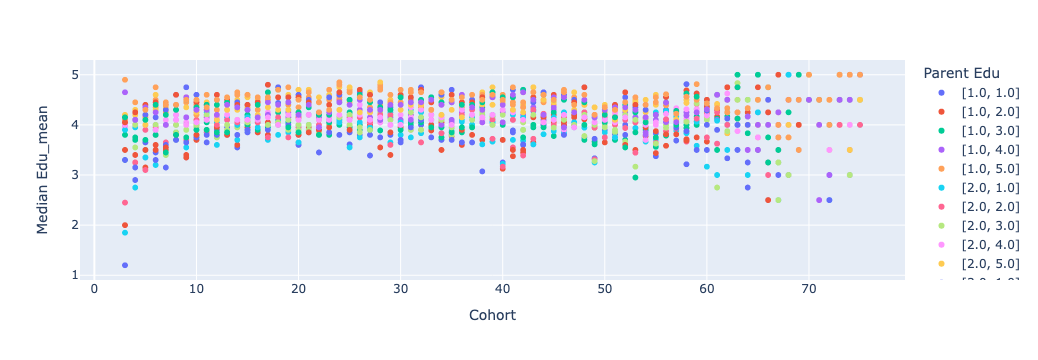

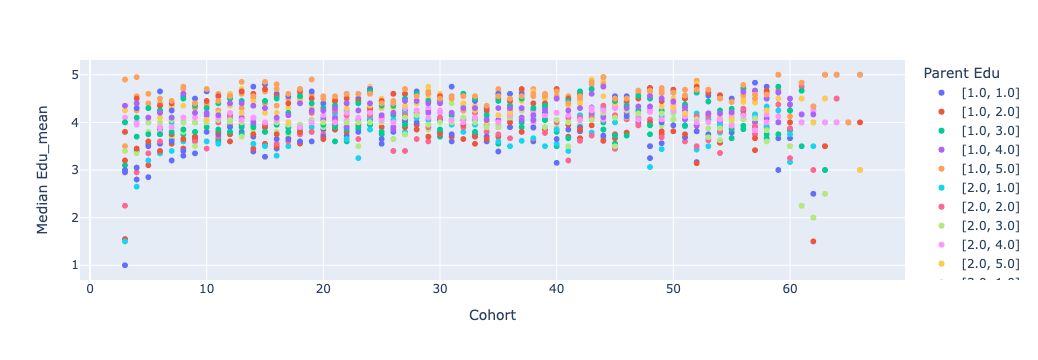

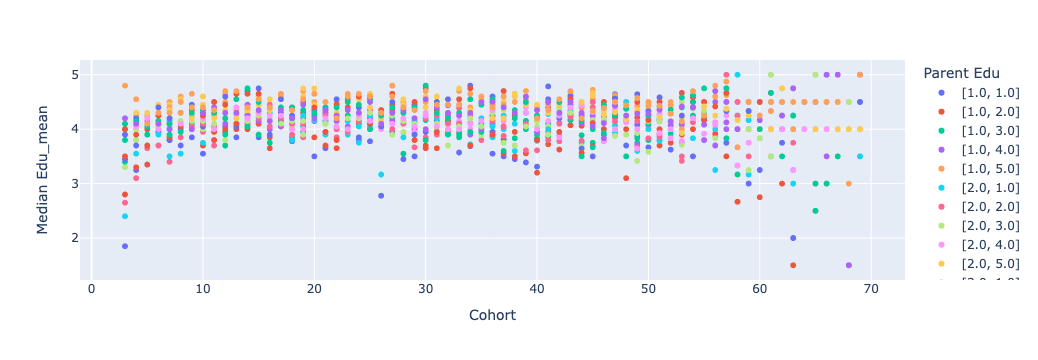

In [67]:
import plotly.express as px

agg_ls["Parent Edu"] = agg_ls["Parent Edu"].astype(str)
data = agg_ls[agg_ls['Scenario'] == 1]
fig1 = px.scatter(data, x='Cohort', y='Median Edu_mean', color='Parent Edu')

agg_ls["Parent Edu"] = agg_ls["Parent Edu"].astype(str)
data = agg_ls[agg_ls['Scenario'] == 2]
fig2 = px.scatter(data, x='Cohort', y='Median Edu_mean', color='Parent Edu')

agg_ls["Parent Edu"] = agg_ls["Parent Edu"].astype(str)
data = agg_ls[agg_ls['Scenario'] == 3]
fig3 = px.scatter(data, x='Cohort', y='Median Edu_mean', color='Parent Edu')

fig1.show()
fig2.show()
fig3.show()

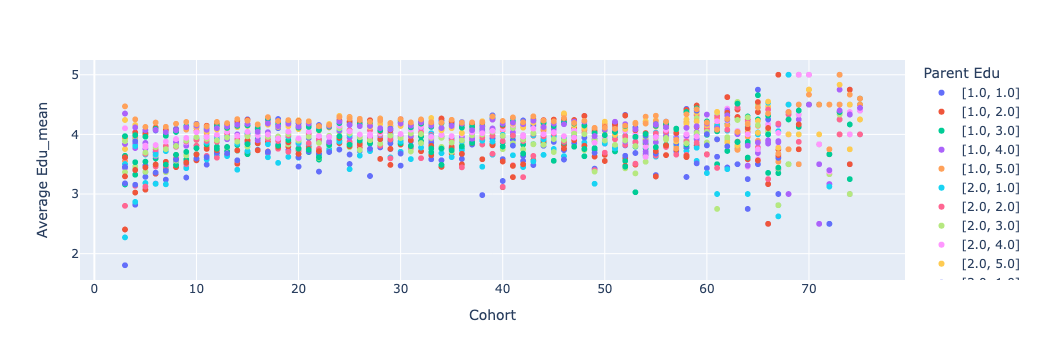

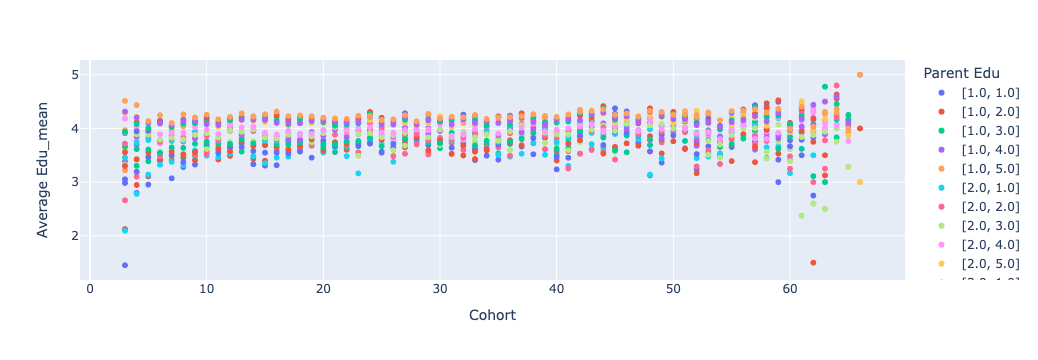

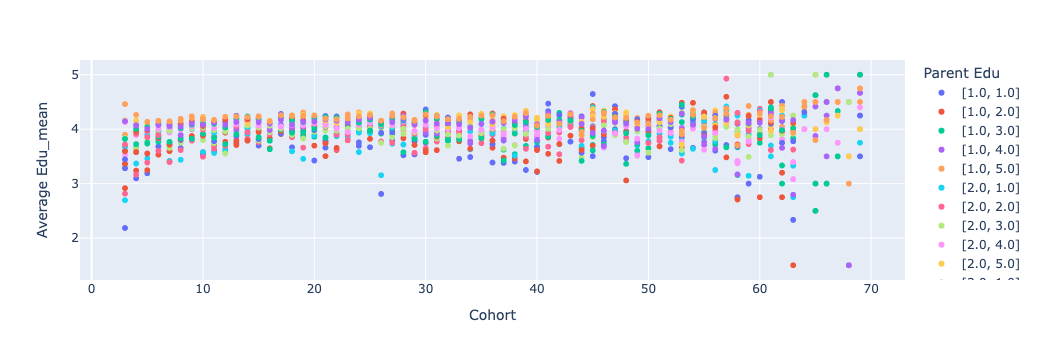

In [231]:
import plotly.express as px

agg_ls["Parent Edu"] = agg_ls["Parent Edu"].astype(str)
data = agg_ls[agg_ls['Scenario'] == 1]
fig1 = px.scatter(data, x='Cohort', y='Average Edu_mean', color='Parent Edu')

agg_ls["Parent Edu"] = agg_ls["Parent Edu"].astype(str)
data = agg_ls[agg_ls['Scenario'] == 2]
fig2 = px.scatter(data, x='Cohort', y='Average Edu_mean', color='Parent Edu')

agg_ls["Parent Edu"] = agg_ls["Parent Edu"].astype(str)
data = agg_ls[agg_ls['Scenario'] == 3]
fig3 = px.scatter(data, x='Cohort', y='Average Edu_mean', color='Parent Edu')

fig1.show()
fig2.show()
fig3.show()

More mixing in scenario 3 compared to 1 and 2. 

In [69]:
agg_ls['Parent Edu 2'] = agg_ls['Parent Edu'].apply(lambda x: '[1, 2]' if x == '[1.0, 2.0]' or x == '[2.0, 1.0]'
                                                    else '[1, 3]' if x == '[1.0, 3.0]' or x == '[3.0, 1.0]'
                                                    else '[1, 4]' if x == '[1.0, 4.0]' or x == '[4.0, 1.0]' 
                                                    else '[1, 5]' if x == '[1.0, 5.0]' or x == '[5.0, 1.0]' 
                                                    else '[2, 3]' if x == '[2.0, 3.0]' or x == '[3.0, 2.0]' 
                                                    else '[2, 4]' if x == '[2.0, 4.0]' or x == '[4.0, 2.0]' 
                                                    else '[2, 5]' if x == '[2.0, 5.0]' or x == '[5.0, 2.0]'
                                                    else '[3, 4]' if x == '[3.0, 4.0]' or x == '[4.0, 3.0]'
                                                    else '[3, 5]' if x == '[3.0, 5.0]' or x == '[5.0, 3.0]' 
                                                    else '[4, 5]' if x == '[4.0, 5.0]' or x == '[5.0, 4.0]' 
                                                    else '[1, 1]' if x == '[1.0, 1.0]'
                                                    else '[2, 2]' if x == '[2.0, 2.0]'
                                                    else '[3, 3]' if x == '[3.0, 3.0]'
                                                    else '[4, 4]' if x == '[4.0, 4.0]'
                                                    else '[5, 5]' if x == '[5.0, 5.0]' 
                                                   else x)

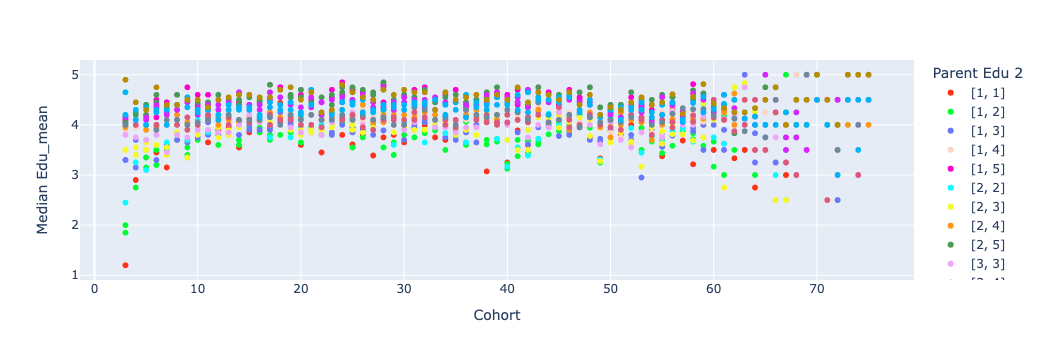

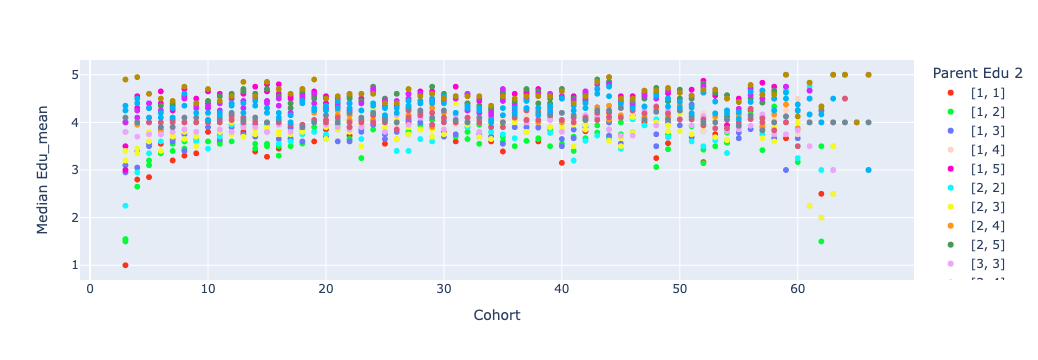

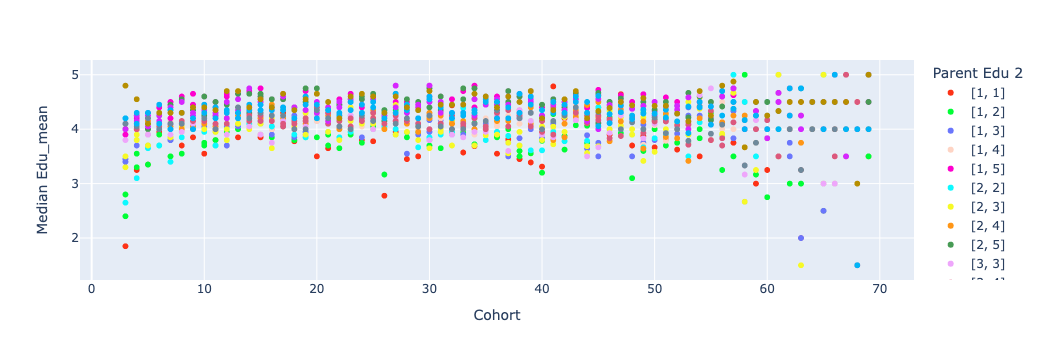

In [70]:
# Looking into average medians.

import plotly.express as px

agg_ls["Parent Edu 2"] = agg_ls["Parent Edu 2"].astype(str)
data = agg_ls[agg_ls['Scenario'] == 1]
fig1 = px.scatter(data, x='Cohort', y='Median Edu_mean', color='Parent Edu 2',
                 color_discrete_sequence=px.colors.qualitative.Light24)

agg_ls["Parent Edu 2"] = agg_ls["Parent Edu 2"].astype(str)
data = agg_ls[agg_ls['Scenario'] == 2]
fig2 = px.scatter(data, x='Cohort', y='Median Edu_mean', color='Parent Edu 2',
                 color_discrete_sequence=px.colors.qualitative.Light24)

agg_ls["Parent Edu 2"] = agg_ls["Parent Edu 2"].astype(str)
data = agg_ls[agg_ls['Scenario'] == 3]
fig3 = px.scatter(data, x='Cohort', y='Median Edu_mean', color='Parent Edu 2',
                 color_discrete_sequence=px.colors.qualitative.Light24)

fig1.show()
fig2.show()
fig3.show()

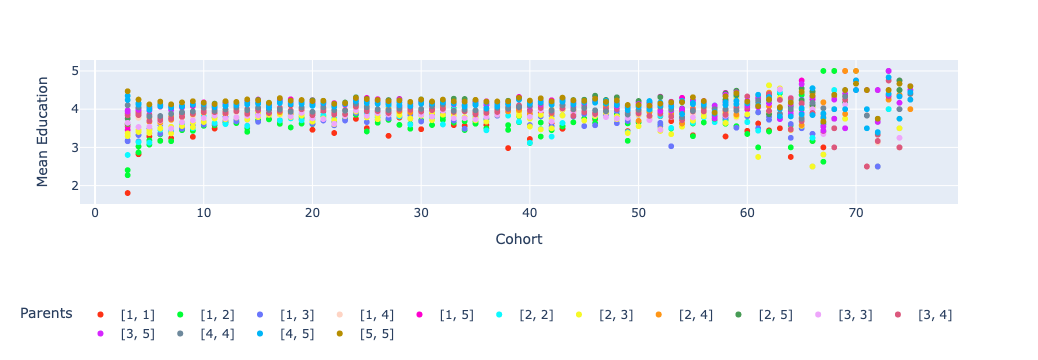

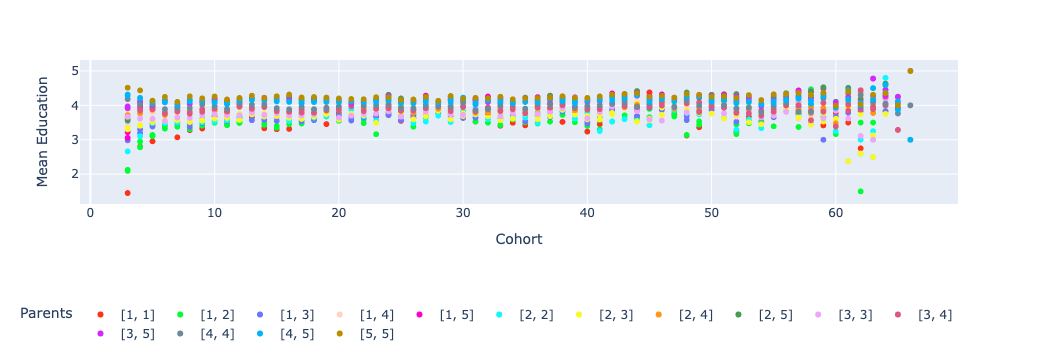

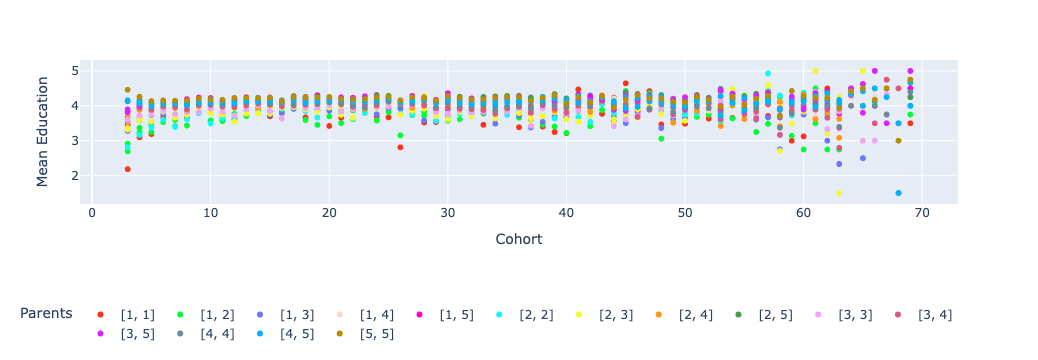

In [399]:
# Looking into average means.

import plotly.express as px

agg_ls["Parent Edu 2"] = agg_ls["Parent Edu 2"].astype(str)
data = agg_ls[agg_ls['Scenario'] == 1]
fig1 = px.scatter(data, x='Cohort', y='Average Edu_mean', color='Parent Edu 2',
                 color_discrete_sequence=px.colors.qualitative.Light24)

agg_ls["Parent Edu 2"] = agg_ls["Parent Edu 2"].astype(str)
data = agg_ls[agg_ls['Scenario'] == 2]
fig2 = px.scatter(data, x='Cohort', y='Average Edu_mean', color='Parent Edu 2',
                 color_discrete_sequence=px.colors.qualitative.Light24)

agg_ls["Parent Edu 2"] = agg_ls["Parent Edu 2"].astype(str)
data = agg_ls[agg_ls['Scenario'] == 3]
fig3 = px.scatter(data, x='Cohort', y='Average Edu_mean', color='Parent Edu 2',
                 color_discrete_sequence=px.colors.qualitative.Light24)


fig1.update_layout(legend=dict(
    title = 'Parents',
    orientation="h",
    yanchor="bottom",
    y=-1,
    xanchor="right",
    x=1),
    xaxis_title="Cohort",
    yaxis_title="Mean Education",
    # paper_bgcolor='rgba(0,0,0,0)',
    # plot_bgcolor = 'rgba(0,0,0,0)',
)

fig2.update_layout(legend=dict(
    title = 'Parents',
    orientation="h",
    yanchor="bottom",
    y=-1,
    xanchor="right",
    x=1),
    xaxis_title="Cohort",
    yaxis_title="Mean Education",
    # paper_bgcolor='rgba(0,0,0,0)',
    # plot_bgcolor = 'rgba(0,0,0,0)',
)

fig3.update_layout(legend=dict(
    title = 'Parents',
    orientation="h",
    yanchor="bottom",
    y=-1,
    xanchor="right",
    x=1),
    xaxis_title="Cohort",
    yaxis_title="Mean Education",
    # paper_bgcolor='rgba(0,0,0,0)',
    # plot_bgcolor = 'rgba(0,0,0,0)',
)
fig1.show()
fig2.show()
fig3.show()

## Variance Differences?

In [382]:
agg_ls

Scenario  Cohort  Mother Edu  Father Edu  Average Edu_mean  \
0            1     3.0         1.0         1.0          1.805588   
1            1     3.0         1.0         2.0          2.405332   
2            1     3.0         1.0         3.0          3.160301   
3            1     3.0         1.0         4.0          3.436475   
4            1     3.0         1.0         5.0          3.553121   
...        ...     ...         ...         ...               ...   
5095         3    69.0         5.0         1.0          4.250000   
5096         3    69.0         5.0         2.0          5.000000   
5097         3    69.0         5.0         3.0          5.000000   
5098         3    69.0         5.0         4.0          4.666667   
5099         3    69.0         5.0         5.0          4.750000   

      Average Edu_sem  Average Edu_std  Median Edu_mean  Median Edu_sem  \
0            0.125877         0.398057              1.2        0.133333   
1            0.089751         0.283817              2.0        0.149071   
2            0.073470         0.232331              3.3        0.152753   
3            0.068618         0.216990              4.0        0.000000   
4            0.076782         0.242806              4.1        0.100000   
...               ...              ...              ...             ...   
5095              NaN              NaN              4.5             NaN   
5096              NaN              NaN              5.0             NaN   
5097              NaN              NaN              5.0             NaN   
5098              NaN              NaN              5.0             NaN   
5099              NaN              NaN              5.0             NaN   

      Median Edu_std  ci95_hi_avg  ci95_lo_avg  ci95_hi_med  ci95_lo_med  \
0           0.421637     2.052307     1.558870     1.461333     0.938667   
1           0.471405     2.581244     2.229421     2.292180     1.707820   
2           0.483046     3.304301     3.016300     3.599395     3.000605   
3           0.000000     3.570967     3.301983     4.000000     4.000000   
4           0.316228     3.703614     3.402628     4.296000     3.904000   
...              ...          ...          ...          ...          ...   
5095             NaN          NaN          NaN          NaN          NaN   
5096             NaN          NaN          NaN          NaN          NaN   
5097             NaN          NaN          NaN          NaN          NaN   
5098             NaN          NaN          NaN          NaN          NaN   
5099             NaN          NaN          NaN          NaN          NaN   

      Parent Edu Parent Edu 2  
0     [1.0, 1.0]       [1, 1]  
1     [1.0, 2.0]       [1, 2]  
2     [1.0, 3.0]       [1, 3]  
3     [1.0, 4.0]       [1, 4]  
4     [1.0, 5.0]       [1, 5]  
...          ...          ...  
5095  [5.0, 1.0]       [1, 5]  
5096  [5.0, 2.0]       [2, 5]  
5097  [5.0, 3.0]       [3, 5]  
5098  [5.0, 4.0]       [4, 5]  
5099  [5.0, 5.0]       [5, 5]  

[5100 rows x 16 columns]

In [232]:
var = agg_ls.groupby(['Scenario', 'Cohort']).agg({'Median Edu_mean': ["mean", "std"], 'Average Edu_mean': ["mean", "std"]}).reset_index()
var.columns = ['_'.join(col) for col in var.columns]
var.rename(columns = {'Scenario_':'Scenario', 'Cohort_':'Cohort', 'Median Edu_mean_mean': 'Med_Mean', 'Median Edu_mean_std': 'Med_Std', 'Average Edu_mean_mean': 'Avg_Mean', 'Average Edu_mean_std': 'Avg_Std'}, inplace = True)
var

Scenario  Cohort  Med_Mean   Med_Std  Avg_Mean   Avg_Std
0           1     3.0  3.646000  0.880805  3.490934  0.636527
1           1     4.0  3.818000  0.454808  3.689232  0.421734
2           1     5.0  3.870000  0.372212  3.693628  0.324290
3           1     6.0  3.994000  0.399301  3.756913  0.313698
4           1     7.0  3.920000  0.379693  3.732800  0.302737
..        ...     ...       ...       ...       ...       ...
199         3    65.0  3.931818  0.820793  3.930303  0.832216
200         3    66.0  4.227273  0.631085  4.115530  0.583324
201         3    67.0  4.250000  0.516398  4.145833  0.484481
202         3    68.0  2.710526  1.346970  2.578947  1.227726
203         3    69.0  4.521739  0.532538  4.394203  0.438938

[204 rows x 6 columns]

In [233]:
s1 = var[(var['Scenario'] == 1) & (var['Cohort'] < 50)]
s2 = var[(var['Scenario'] == 2) & (var['Cohort'] < 50)]
s3 = var[(var['Scenario'] == 3) & (var['Cohort'] < 50)]

In [252]:
print(s3.Med_Std.values-s2.Med_Std.values)
print(s3.Med_Std.values-s1.Med_Std.values)
print(s2.Med_Std.values-s1.Med_Std.values)

[-0.3076689  -0.2684566  -0.19659543 -0.16054117 -0.04953982 -0.18434338
 -0.14512589 -0.04550704 -0.09582101 -0.01048435 -0.11357639 -0.189843
 -0.14875835 -0.16533132 -0.11169519 -0.1507812  -0.03841684 -0.03063962
 -0.03330194 -0.08556404 -0.09500767 -0.04477478 -0.03875858  0.02978623
 -0.0723061   0.02692499 -0.08013223  0.05872776 -0.05267146 -0.05519698
 -0.02595229  0.10427885 -0.10739506  0.01405885  0.07052315  0.05789833
  0.08667103 -0.12353525 -0.08018009 -0.06390017 -0.17193999 -0.16512525
 -0.02655641  0.01047145 -0.00859743 -0.13938087  0.00540867]
[-0.22165738 -0.11132063 -0.10179551 -0.20895092 -0.1092457  -0.04156686
 -0.23024139  0.00396019 -0.00268403  0.01967538 -0.04929381 -0.10607318
  0.03933154  0.04608291 -0.14823063 -0.07767611  0.01630065 -0.06069624
 -0.07536208 -0.01822171  0.00826033 -0.03827028 -0.08620079  0.05629908
 -0.02318519 -0.02233687 -0.04534178  0.03953974 -0.02604862 -0.06854294
  0.05820344 -0.00318319 -0.03940767 -0.03572787  0.11661576  0.

In [253]:
# Mostly, s2's std is larger than s3's because we are looking at the data already organized by parents' educational level. 
# So in S2, mobility is more stable & smaller variance in mobility --> this is reflected as larger variance here. 
print(s3.Avg_Std.values-s2.Avg_Std.values)
print(s3.Avg_Std.values-s1.Avg_Std.values)
print(s2.Avg_Std.values-s1.Avg_Std.values)

[-2.34483381e-01 -1.42626222e-01 -6.59710181e-02 -1.18617295e-01
 -4.53999506e-02 -1.12200502e-01 -1.22635359e-01 -1.13440120e-02
 -3.91110825e-02 -3.14806059e-02 -4.83818110e-02 -1.39861015e-01
 -1.19527848e-01 -1.16295441e-01 -1.10600321e-01 -4.96110454e-02
 -8.41101937e-03 -3.22967525e-02  1.09866943e-03 -2.97388456e-02
 -1.16854679e-01 -9.62448166e-03 -5.17809714e-02  1.00769565e-01
 -5.11572189e-02  7.46434785e-02 -5.20269712e-02  2.06773864e-02
 -3.19976403e-02 -7.61720943e-02 -8.18144822e-02  1.64616915e-02
 -9.10936728e-02 -1.26123247e-02  2.93940200e-02  7.02281927e-02
  7.96662544e-02 -2.32514451e-02 -8.91650856e-02 -2.33194417e-02
 -9.04030321e-02 -5.64181927e-02  1.45713564e-02  4.38732133e-02
 -1.23154053e-04 -4.66419434e-02 -5.06926422e-02]
[-0.1333532  -0.0984821  -0.05403865 -0.14524223 -0.0799447  -0.03741794
 -0.12563311  0.0200728   0.00503713  0.01327563 -0.02555202 -0.13200586
 -0.01499285  0.04116241 -0.08897689 -0.00944329  0.01443625 -0.0409269
  0.02061694 -0.0

# A More Detailed Assessment on Who Benefits

In [180]:
'''
    Make a function to create summary tables for each data set
'''
def simple_tab(df):
    ls = pd.DataFrame()
    row = 0
    for i in df.Cohort.unique():
        cht = df[df['Cohort'] == i]
        for j in range(1, 6):
            for k in range(1, 6):
                ls.loc[row, 'Cohort'] = i
                ls.loc[row, 'Mother Edu'] = j
                ls.loc[row, 'Father Edu'] = k
                row += 1
    return ls

In [181]:
ls_full2 = pd.DataFrame()
row = 0
for i in range(1, num_scen+1):
    for j in range(1,num_reps+1):
        df = dfs[row]
        df2 =  df[df['Generation'] != 1]
        df3 = simple_tab(df2)
        df3['Scenario'] = i
        df3['Replication'] = j
        df3['Edu_level'] = df['Edu_level']
        ls_full2 = pd.concat([ls_full2, df3], ignore_index=True)
        row +=1

In [183]:
ls_full2

Cohort  Mother Edu  Father Edu  Scenario  Replication  Edu_level
0         7.0         1.0         1.0         1            1          4
1         7.0         1.0         2.0         1            1          2
2         7.0         1.0         3.0         1            1          3
3         7.0         1.0         4.0         1            1          3
4         7.0         1.0         5.0         1            1          4
...       ...         ...         ...       ...          ...        ...
42270    65.0         5.0         1.0         3           10          1
42271    65.0         5.0         2.0         3           10          5
42272    65.0         5.0         3.0         3           10          5
42273    65.0         5.0         4.0         3           10          5
42274    65.0         5.0         5.0         3           10          4

[42275 rows x 6 columns]

In [184]:
ls_full2['Parent Edu'] = ls_full2.apply(lambda x: [x['Mother Edu'], x['Father Edu']], axis=1)
ls_full2['Parent Edu'] = ls_full2['Parent Edu'].astype(str)
ls_full2['Parent Edu 2'] = ls_full2['Parent Edu'].apply(lambda x: '[1, 2]' if x == '[1.0, 2.0]' or x == '[2.0, 1.0]'
                                                    else '[1, 3]' if x == '[1.0, 3.0]' or x == '[3.0, 1.0]'
                                                    else '[1, 4]' if x == '[1.0, 4.0]' or x == '[4.0, 1.0]' 
                                                    else '[1, 5]' if x == '[1.0, 5.0]' or x == '[5.0, 1.0]' 
                                                    else '[2, 3]' if x == '[2.0, 3.0]' or x == '[3.0, 2.0]' 
                                                    else '[2, 4]' if x == '[2.0, 4.0]' or x == '[4.0, 2.0]' 
                                                    else '[2, 5]' if x == '[2.0, 5.0]' or x == '[5.0, 2.0]'
                                                    else '[3, 4]' if x == '[3.0, 4.0]' or x == '[4.0, 3.0]'
                                                    else '[3, 5]' if x == '[3.0, 5.0]' or x == '[5.0, 3.0]' 
                                                    else '[4, 5]' if x == '[4.0, 5.0]' or x == '[5.0, 4.0]' 
                                                    else '[1, 1]' if x == '[1.0, 1.0]'
                                                    else '[2, 2]' if x == '[2.0, 2.0]'
                                                    else '[3, 3]' if x == '[3.0, 3.0]'
                                                    else '[4, 4]' if x == '[4.0, 4.0]'
                                                    else '[5, 5]' if x == '[5.0, 5.0]' 
                                                   else x)
ls_full2

Cohort  Mother Edu  Father Edu  Scenario  Replication  Edu_level  \
0         7.0         1.0         1.0         1            1          4   
1         7.0         1.0         2.0         1            1          2   
2         7.0         1.0         3.0         1            1          3   
3         7.0         1.0         4.0         1            1          3   
4         7.0         1.0         5.0         1            1          4   
...       ...         ...         ...       ...          ...        ...   
42270    65.0         5.0         1.0         3           10          1   
42271    65.0         5.0         2.0         3           10          5   
42272    65.0         5.0         3.0         3           10          5   
42273    65.0         5.0         4.0         3           10          5   
42274    65.0         5.0         5.0         3           10          4   

       Parent Edu Parent Edu 2  
0      [1.0, 1.0]       [1, 1]  
1      [1.0, 2.0]       [1, 2]  
2      [1.0, 3.0]       [1, 3]  
3      [1.0, 4.0]       [1, 4]  
4      [1.0, 5.0]       [1, 5]  
...           ...          ...  
42270  [5.0, 1.0]       [1, 5]  
42271  [5.0, 2.0]       [2, 5]  
42272  [5.0, 3.0]       [3, 5]  
42273  [5.0, 4.0]       [4, 5]  
42274  [5.0, 5.0]       [5, 5]  

[42275 rows x 8 columns]

In [195]:
ls_full3 = ls_full2.groupby(['Scenario', 'Cohort', 'Edu_level', 'Parent Edu 2'])['Parent Edu 2'].size().reset_index(name='Size')
ls_full3

Scenario  Cohort  Edu_level Parent Edu 2  Size
0             1     3.0          1       [1, 1]     1
1             1     3.0          1       [1, 2]     2
2             1     3.0          1       [1, 3]     1
3             1     3.0          1       [1, 5]     3
4             1     3.0          1       [2, 3]     3
...         ...     ...        ...          ...   ...
11786         3    69.0          5       [2, 4]     1
11787         3    69.0          5       [2, 5]     1
11788         3    69.0          5       [3, 3]     1
11789         3    69.0          5       [3, 4]     1
11790         3    69.0          5       [4, 5]     1

[11791 rows x 5 columns]

In [208]:
add = ls_full2.groupby(['Scenario', 'Cohort', 'Parent Edu 2'])['Parent Edu 2'].size().reset_index(name='Total')

ls_full4 = pd.merge(ls_full3, add)
ls_full4['Perc'] = ls_full4['Size']/ls_full4['Total']
ls_full4

Scenario  Cohort Edu_level Parent Edu 2  Size  Total  Perc
0             1     3.0         1       [1, 1]     1     10   0.1
1             1     3.0         2       [1, 1]     2     10   0.2
2             1     3.0         3       [1, 1]     1     10   0.1
3             1     3.0         4       [1, 1]     2     10   0.2
4             1     3.0         5       [1, 1]     4     10   0.4
...         ...     ...       ...          ...   ...    ...   ...
11786         3    69.0         5       [2, 4]     1      2   0.5
11787         3    69.0         4       [3, 4]     1      2   0.5
11788         3    69.0         5       [3, 4]     1      2   0.5
11789         3    69.0         4       [3, 5]     2      2   1.0
11790         3    69.0         5       [3, 3]     1      1   1.0

[11791 rows x 7 columns]

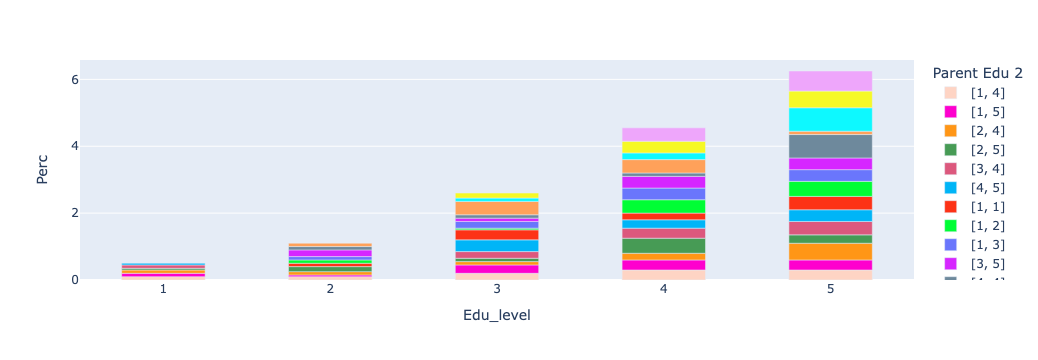

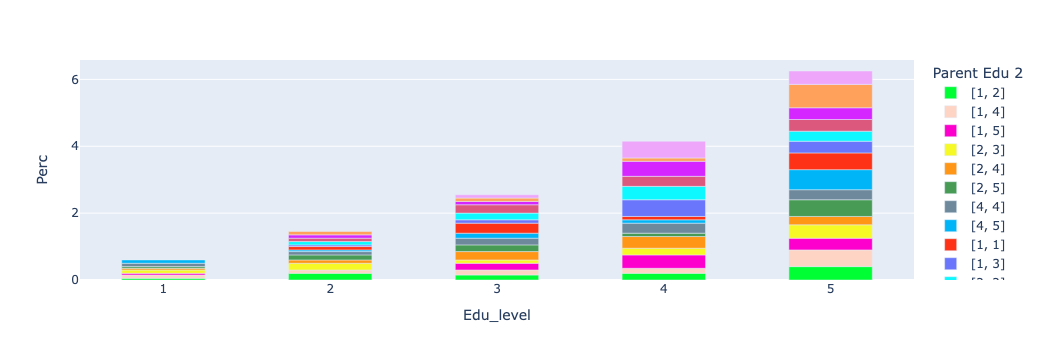

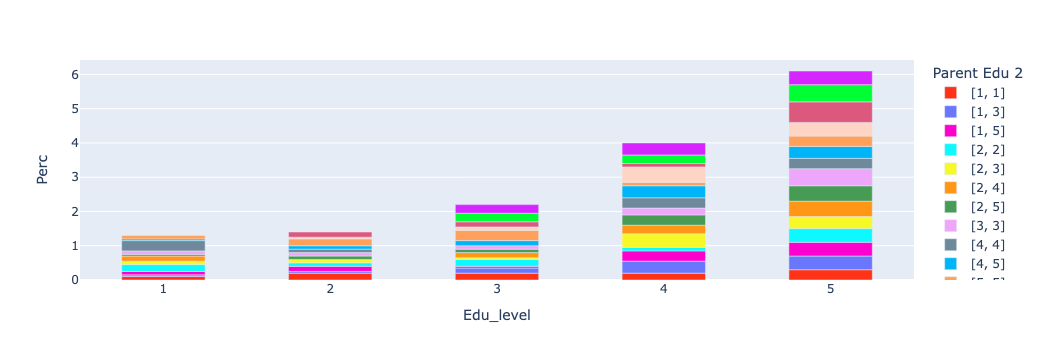

In [228]:
import plotly.express as px
colormap = {'[1, 1]': px.colors.qualitative.Light24[0], '[1, 2]': px.colors.qualitative.Light24[1],
            '[1, 3]': px.colors.qualitative.Light24[2], '[1, 4]': px.colors.qualitative.Light24[3],
            '[1, 5]': px.colors.qualitative.Light24[4], '[2, 2]': px.colors.qualitative.Light24[5],
            '[2, 3]': px.colors.qualitative.Light24[6], '[2, 4]': px.colors.qualitative.Light24[7],
            '[2, 5]': px.colors.qualitative.Light24[8], '[3, 3]': px.colors.qualitative.Light24[9],
            '[3, 4]': px.colors.qualitative.Light24[10], '[3, 5]': px.colors.qualitative.Light24[11],
            '[4, 4]': px.colors.qualitative.Light24[12], '[4, 5]': px.colors.qualitative.Light24[13]
           }

ls_full4["Parent Edu 2"] = ls_full4["Parent Edu 2"].astype(str)
ls_full4["Edu_level"] = ls_full4["Edu_level"].astype(str)

scenarios = [1, 2, 3]
cohort = 4 # Change the cohort
figs = []

for scenario in scenarios:
    data = ls_full4[(ls_full4['Scenario'] == scenario) & (ls_full4['Cohort'] == 4)]
    fig = px.bar(data, x='Edu_level', y='Perc', color='Parent Edu 2', color_discrete_map=colormap)
    fig.update_traces(width=0.5)
    figs.append(fig)

for fig in figs:
    fig.show()

# End